In [1]:
import sys
import pickle
from pathlib import Path

from dotenv import find_dotenv, load_dotenv
# find .env automagically by walking up directories until it's found, then
# load up the .env entries as environment variables
load_dotenv(find_dotenv())

PROJ_ROOT = Path('/home/jupyter/gama/bruno')

from tqdm.notebook import tqdm

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

Python-dotenv could not parse statement starting at line 6
Python-dotenv could not parse statement starting at line 8
Python-dotenv could not parse statement starting at line 9
Python-dotenv could not parse statement starting at line 11
Python-dotenv could not parse statement starting at line 12


# Data

In [2]:
import wandb

import torch
from torchvision import models
from torch import nn

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def load_from_wandb(net: nn.Module, run_id: str,
                    project='ADNI-brain-age', model_fname='model_last'):
    best_model_file = wandb.restore(
        model_fname+'.pth',
        run_path=f"gama/{project}/{run_id}",
        replace=True
    )
    net.load_state_dict(torch.load(best_model_file.name))

    return net

class BraTSnnUNet(nn.Module):
    def __init__(self, network, freeze=False):
        """`network` must be a nnU-Net `Generic_UNet`.
        """
        super().__init__()

        self.brats_encoder = network.conv_blocks_context

        self.pooling = nn.AvgPool2d(5)

        self.fc = nn.Linear(480,1)

        if freeze:
            self.freeze()

    def forward(self, x):
        for d in range(len(self.brats_encoder)):
            x = self.brats_encoder[d](x)

        x = self.pooling(x)

        y = self.fc(x.squeeze()).squeeze()

        return y

    def freeze(self):
        for param in self.brats_encoder.parameters():
            param.requires_grad = False

    def unfreeze(self):
        for param in self.model.brats_encoder.parameters():
            param.requires_grad = True

In [14]:
import h5py

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

DATASET_FPATH = Path('/home/jupyter/gama/bruno/data/interim/ADNI123_slices_fix_2mm_split_class.hdf5')

class ADNIDataset(Dataset):
    def __init__(
        self,
        hdf5_fpath,
        transform=torch.Tensor,
        dataset='train',
    ) -> None:
        super().__init__()

        hdf5_fpath = Path(hdf5_fpath)
        assert hdf5_fpath.exists()

        self._fpath = hdf5_fpath
        self.dataset = dataset

        self.transform = transform

    def __len__(self):
        with h5py.File(self._fpath, 'r') as h:
            if self.dataset == 'train+val':
                l = h['train']['y'].shape[0]
                l += h['val']['y'].shape[0]
            else:
                l = h[self.dataset]['y'].shape[0]

        return l

    def __getitem__(self, index: int):
        if self.dataset == 'train+val':
            with h5py.File(self._fpath, 'r') as h:
                train_len = h['train']['y'].shape[0]
            index_ = index - train_len

            if index_ < 0:
                dataset = 'train'
            else:
                dataset = 'val'
        else:
            index_ = index
            dataset = self.dataset

        with h5py.File(self._fpath, 'r') as h:
            img = h[dataset]['X'][index_]
            age = h[dataset]['a'][index_]
            label = h[dataset]['y'][index_]

        # transform
        if self.transform is not None:
            img = self.transform(img)

        return img, age, label

h = lambda x: x*25+75

data = ADNIDataset(DATASET_FPATH, dataset='val')
data_loader = DataLoader(data, batch_size=40, shuffle=False)

len(data) / 40

504.0

In [6]:
len(ADNIDataset(DATASET_FPATH, dataset='test')) / 40

770.0

In [7]:
len(ADNIDataset(DATASET_FPATH, dataset='train')) / 40

4719.0

In [64]:
net = torch.load(PROJ_ROOT/'models/brats_model.pt')
net.pooling = nn.AvgPool2d(3)
net = load_from_wandb(net, '3h05qyn7').to(device)  # efficient-mountain-368
# net = load_from_wandb(net, '18721a16').to(device)  # electric-cherry-345
net.eval()
net

BraTSnnUNet(
  (brats_encoder): ModuleList(
    (0): StackedConvLayers(
      (blocks): Sequential(
        (0): ConvDropoutNormNonlin(
          (conv): Conv2d(1, 32, kernel_size=[3, 3], stride=(1, 1), padding=[1, 1])
          (instnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (lrelu): LeakyReLU(negative_slope=0.01, inplace=True)
        )
        (1): ConvDropoutNormNonlin(
          (conv): Conv2d(32, 32, kernel_size=[3, 3], stride=(1, 1), padding=[1, 1])
          (instnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (lrelu): LeakyReLU(negative_slope=0.01, inplace=True)
        )
      )
    )
    (1): StackedConvLayers(
      (blocks): Sequential(
        (0): ConvDropoutNormNonlin(
          (conv): Conv2d(32, 64, kernel_size=[3, 3], stride=[2, 2], padding=[1, 1])
          (instnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (lrelu)

# Threshold tuning

  0%|          | 0/504 [00:00<?, ?it/s]

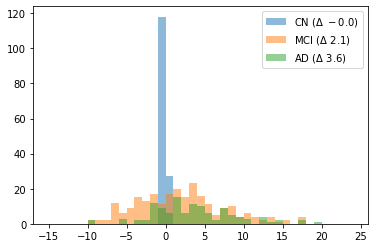

In [46]:
data = ADNIDataset(DATASET_FPATH, dataset='val')
data_loader = DataLoader(data, batch_size=40, shuffle=False)

age_deltas = list()
groups = list()
for X, a, y in tqdm(data_loader):
    with torch.no_grad():
        a_pred = h(net(X.unsqueeze(1).to(device))).detach().cpu()
    age_deltas.append(a_pred.numpy().mean() - a.cpu().numpy().mean())
    groups.append(y.cpu().numpy().min())
age_deltas = np.array(age_deltas)
groups = np.array(groups)

bins = np.arange(-15,25)
plt.hist(age_deltas[groups == 0], bins=bins, alpha=0.5, label=f"CN ($\Delta ~ {age_deltas[groups == 0].mean():.1f}$)")
plt.hist(age_deltas[groups == 3], bins=bins, alpha=0.5, label=f"MCI ($\Delta ~ {age_deltas[groups == 3].mean():.1f}$)")
plt.hist(age_deltas[groups == 4], bins=bins, alpha=0.5, label=f"AD ($\Delta ~ {age_deltas[groups == 4].mean():.1f}$)")
plt.legend()
plt.show()

In [47]:
df = pd.concat([pd.Series(age_deltas), pd.Series(groups)], axis=1)
df.columns = ['Delta', 'Group']
df['Group'] = df['Group'].replace({0:'CN', 3:'MCI', 4:'AD'})
df.groupby('Group').agg([np.mean, np.std])

Delta          
           mean       std
Group                    
AD     3.635426  5.276085
CN    -0.034257  0.033880
MCI    2.061017  5.596952

## AD vs. CN

/opt/conda/envs/bruno/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


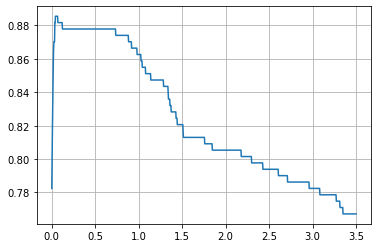

In [49]:
df_adcn = df[df['Group'] != 'MCI']
df_adcn['Label'] = df_adcn['Group'] == 'AD'

thresholds = np.linspace(0, 3.5, 1000)

accs = list()
for thresh in thresholds:
    pred = df_adcn['Delta'] > thresh
    accs.append(sum(pred == df_adcn['Label']) / len(pred))
accs = np.array(accs)

plt.plot(thresholds, accs)
plt.grid()
plt.show()

In [50]:
threshold = thresholds[np.argmax(accs)]
print(f"Best threshold = {threshold:.2f}")

Best threshold = 0.04


# Prediction

In [61]:
threshold = 2.62  # tuned using model trained only on training data
# threshold = 1.00  # tuned using model trained on train+val data

In [65]:
data = ADNIDataset(DATASET_FPATH, dataset='test')
data_loader = DataLoader(data, batch_size=40, shuffle=False)

age_deltas = list()
groups = list()
for X, a, y in tqdm(data_loader):
    with torch.no_grad():
        a_pred = h(net(X.unsqueeze(1).to(device))).detach().cpu()
    age_deltas.append(a_pred.numpy().mean() - a.cpu().numpy().mean())
    groups.append(y.cpu().numpy().min())
age_deltas = np.array(age_deltas)
groups = np.array(groups)

df_test = pd.concat([pd.Series(age_deltas), pd.Series(groups)], axis=1)
df_test.columns = ['Delta', 'Group']
df_test['Group'] = df_test['Group'].replace({0:'CN', 3:'MCI', 4:'AD'})
df_test.groupby('Group').agg([np.mean, np.std])

  0%|          | 0/770 [00:00<?, ?it/s]

Delta          
           mean       std
Group                    
AD     3.745560  5.832286
CN    -0.956460  3.790586
MCI    2.323889  5.493431

In [99]:
df_test

,Delta,Group
0,-1.316277,CN
1,-8.554657,CN
2,5.399956,MCI
3,-10.196373,MCI
4,5.902969,MCI
...,...,...
765,3.028854,AD
766,-2.441895,AD
767,-5.469353,CN
768,4.965820,MCI


In [104]:
from scipy.stats import f_oneway

f_oneway(df[df.Group == 'AD']['Delta'].values, df[df.Group == 'MCI']['Delta'].values, df[df.Group == 'CN']['Delta'].values)

F_onewayResult(statistic=20.874347814365052, pvalue=1.9604412647074833e-09)

In [66]:
df_adcn = df_test[df_test['Group'] != 'MCI']
labels = (df_adcn['Group'] == 'AD')

pred = df_adcn['Delta'] > threshold
acc = sum(pred == labels) / len(pred)

print(f"Test accuracy = {100*acc:.2f}%")
print(f"Test AUC = {roc_auc_score(pred, labels):.2f}")

Test accuracy = 68.21%
Test AUC = 0.68


# Cohen's D

In [113]:
#correct if the population S.D. is expected to be equal for the two groups.
def cohen_d(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)

cohen_d(age_deltas[groups == 4], age_deltas[groups == 0])

0.7680749020956529

In [114]:
cohen_d(age_deltas[groups == 3], age_deltas[groups == 0])

0.5414401416499476

In [115]:
cohen_d(age_deltas[groups == 4], age_deltas[groups == 3])

0.16079192157911917

# Analysis

In [14]:
runs_meta = pd.read_csv('../runs_meta.csv')
runs_meta = runs_meta.set_index('ID')
runs_meta

,Name,Group,Runtime,Notes,State,Tags,batch_size,epochs,learning_rate,loss_func,lr_scheduler,lr_scheduler_params.lr_lambda,model,split,train_loss,val_MAE,val_loss,val_ps_MAE
ID,,,,,,,,,,,,,,,,,,
10hkql4a,sparkling-sponge-364,ADNI23_LR_UNet+old_MAPER,5462,-,finished,NaN,64,30,0.001,MSELoss,MultiplicativeLR,__main__.<lambda>,BraTSnnUNet,train+val,0.001078,3.399155,18.491207,3.054078
1nmolgfp,elated-oath-342,ADNI23_LR_UNet+old_MAPER,5316,-,finished,NaN,64,30,0.001,MSELoss,MultiplicativeLR,__main__.<lambda>,BraTSnnUNet,train+val,0.001096,3.458556,18.839183,3.068109
71b3v5g5,fast-sun-352,ADNI23_LR_UNet+old_MAPER,5518,-,finished,NaN,64,30,0.001,MSELoss,MultiplicativeLR,__main__.<lambda>,BraTSnnUNet,train+val,0.001064,3.416998,18.512721,3.095097
eu5yasfb,fine-wood-358,ADNI23_LR_UNet+old_MAPER,5458,-,finished,NaN,64,30,0.001,MSELoss,MultiplicativeLR,__main__.<lambda>,BraTSnnUNet,train+val,0.001111,3.387260,18.377423,3.060410
xq1n7hlt,royal-bee-346,ADNI23_LR_UNet+old_MAPER,5532,-,finished,NaN,64,30,0.001,MSELoss,MultiplicativeLR,__main__.<lambda>,BraTSnnUNet,train+val,0.001164,3.450090,18.841739,3.109362
1u0ce6cf,solar-forest-353,ADNI23_LR_UNet+old_FSL_BrainSeg,5149,-,finished,NaN,64,30,0.001,MSELoss,MultiplicativeLR,__main__.<lambda>,BraTSnnUNet,train+val,0.044604,3.420150,18.155492,3.031086
1vj2xtnm,easy-water-343,ADNI23_LR_UNet+old_FSL_BrainSeg,4897,-,finished,NaN,64,30,0.001,MSELoss,MultiplicativeLR,__main__.<lambda>,BraTSnnUNet,train+val,0.042271,3.381946,17.669436,2.980391
247apxie,driven-sun-359,ADNI23_LR_UNet+old_FSL_BrainSeg,5134,-,finished,NaN,64,30,0.001,MSELoss,MultiplicativeLR,__main__.<lambda>,BraTSnnUNet,train+val,0.044849,3.409376,18.074892,3.022462
3s2psjrx,resilient-silence-365,ADNI23_LR_UNet+old_FSL_BrainSeg,5071,-,finished,NaN,64,30,0.001,MSELoss,MultiplicativeLR,__main__.<lambda>,BraTSnnUNet,train+val,0.043376,3.400648,17.910982,3.034046


In [3]:
df = pd.read_csv('../preds.csv', index_col=0)
df

,Delta,Group,id,name,run_group,model,split,val_MAE,val_ps_MAE
0,-2.308647,CN,10hkql4a,sparkling-sponge-364,ADNI23_LR_UNet+old_MAPER,BraTSnnUNet,train+val,3.399155,3.054078
1,-5.329765,CN,10hkql4a,sparkling-sponge-364,ADNI23_LR_UNet+old_MAPER,BraTSnnUNet,train+val,3.399155,3.054078
2,6.313271,MCI,10hkql4a,sparkling-sponge-364,ADNI23_LR_UNet+old_MAPER,BraTSnnUNet,train+val,3.399155,3.054078
3,-6.215050,MCI,10hkql4a,sparkling-sponge-364,ADNI23_LR_UNet+old_MAPER,BraTSnnUNet,train+val,3.399155,3.054078
4,7.634407,MCI,10hkql4a,sparkling-sponge-364,ADNI23_LR_UNet+old_MAPER,BraTSnnUNet,train+val,3.399155,3.054078
...,...,...,...,...,...,...,...,...,...
765,-1.191925,AD,c0gh239e,dandy-dust-339,ADNI23_LR_ResNet50,ResNet,train+val,3.616925,3.038406
766,-6.383339,AD,c0gh239e,dandy-dust-339,ADNI23_LR_ResNet50,ResNet,train+val,3.616925,3.038406
767,-4.243248,CN,c0gh239e,dandy-dust-339,ADNI23_LR_ResNet50,ResNet,train+val,3.616925,3.038406
768,3.363213,MCI,c0gh239e,dandy-dust-339,ADNI23_LR_ResNet50,ResNet,train+val,3.616925,3.038406


In [7]:
summary = df.groupby(['id', 'Group', 'name', 'run_group', 'model'])['Delta'].agg([np.mean, np.std])
summary

mean  \
id       Group name                     run_group                   model                   
10b82odi AD    misunderstood-dragon-355 ADNI23_LR_ResNet50+ImageNet ResNet       2.515800   
         CN    misunderstood-dragon-355 ADNI23_LR_ResNet50+ImageNet ResNet      -0.717357   
         MCI   misunderstood-dragon-355 ADNI23_LR_ResNet50+ImageNet ResNet       1.919315   
10hkql4a AD    sparkling-sponge-364     ADNI23_LR_UNet+old_MAPER    BraTSnnUNet  2.378535   
         CN    sparkling-sponge-364     ADNI23_LR_UNet+old_MAPER    BraTSnnUNet -0.442463   
...                                                                                   ...   
eu5yasfb CN    fine-wood-358            ADNI23_LR_UNet+old_MAPER    BraTSnnUNet -0.359709   
         MCI   fine-wood-358            ADNI23_LR_UNet+old_MAPER    BraTSnnUNet  2.014108   
xq1n7hlt AD    royal-bee-346            ADNI23_LR_UNet+old_MAPER    BraTSnnUNet  2.399342   
         CN    royal-bee-346            ADNI23_LR_UNet+old_MAPER    BraTSnnUNet -0.513093   
         MCI   royal-bee-346            ADNI23_LR_UNet+old_MAPER    BraTSnnUNet  1.956519   

                                                                                      std  
id       Group name                     run_group                   model                  
10b82odi AD    misunderstood-dragon-355 ADNI23_LR_ResNet50+ImageNet ResNet       6.151675  
         CN    misunderstood-dragon-355 ADNI23_LR_ResNet50+ImageNet ResNet       3.681831  
         MCI   misunderstood-dragon-355 ADNI23_LR_ResNet50+ImageNet ResNet       5.920462  
10hkql4a AD    sparkling-sponge-364     ADNI23_LR_UNet+old_MAPER    BraTSnnUNet  6.216727  
         CN    sparkling-sponge-364     ADNI23_LR_UNet+old_MAPER    BraTSnnUNet  3.707944  
...                                                                                   ...  
eu5yasfb CN    fine-wood-358            ADNI23_LR_UNet+old_MAPER    BraTSnnUNet  3.681427  
         MCI   fine-wood-358            ADNI23_LR_UNet+old_MAPER    BraTSnnUNet  5.889021  
xq1n7hlt AD    royal-bee-346            ADNI23_LR_UNet+old_MAPER    BraTSnnUNet  6.199940  
         CN    royal-bee-346            ADNI23_LR_UNet+old_MAPER    BraTSnnUNet  3.736309  
         MCI   royal-bee-346            ADNI23_LR_UNet+old_MAPER    BraTSnnUNet  5.930340  

[90 rows x 2 columns]

In [26]:
from scipy.stats import kruskal, f_oneway

analysis = list()
for run_id in df['id'].unique():
    run_data = df[df['id'] == run_id]
    run_data.groupby(['id', 'Group', 'name', 'run_group', 'model'])['Delta'].agg([np.mean, np.std])

    cn = run_data[run_data['Group'] == 'CN']['Delta'].values
    mci = run_data[run_data['Group'] == 'MCI']['Delta'].values
    ad = run_data[run_data['Group'] == 'AD']['Delta'].values

    analysis.append({
        'id': run_id,
        'group': runs_meta.loc[run_id]['Group'],
        'anova_cn_mci_F': f_oneway(cn, mci).statistic,
        'anova_cn_ad_F': f_oneway(cn, ad).statistic,
        'anova_mci_ad_F': f_oneway(mci, ad).statistic,
        'anova_cn_mci': f_oneway(cn, mci).pvalue,
        'anova_cn_ad': f_oneway(cn, ad).pvalue,
        'anova_mci_ad': f_oneway(mci, ad).pvalue,
        'kruskal_cn_mci_H': kruskal(cn, mci).statistic,
        'kruskal_cn_ad_H': kruskal(cn, ad).statistic,
        'kruskal_mci_ad_H': kruskal(mci, ad).statistic,
        'kruskal_cn_mci': kruskal(cn, mci).pvalue,
        'kruskal_cn_ad': kruskal(cn, ad).pvalue,
        'kruskal_mci_ad': kruskal(mci, ad).pvalue,
    })
analysis = pd.DataFrame(analysis)

analysis.groupby('group')[['kruskal_cn_mci', 'kruskal_cn_ad', 'kruskal_mci_ad',
                           'anova_cn_mci', 'anova_cn_ad', 'anova_mci_ad']].agg([np.mean, np.std])

kruskal_cn_mci               kruskal_cn_ad  \
                                          mean           std          mean   
group                                                                        
ADNI23_LR_ResNet50                2.321704e-06  1.760229e-06  6.619128e-06   
ADNI23_LR_ResNet50+ImageNet       2.812726e-08  1.899577e-08  4.403642e-07   
ADNI23_LR_UNet                    3.354186e-09  3.563922e-09  8.165333e-09   
ADNI23_LR_UNet+BraTS              5.409818e-10  2.541590e-10  1.214406e-10   
ADNI23_LR_UNet+old_FSL_BrainSeg   5.462836e-09  1.925608e-09  3.575157e-09   
ADNI23_LR_UNet+old_MAPER          3.088445e-07  2.344742e-07  2.748234e-06   

                                              kruskal_mci_ad            \
                                          std           mean       std   
group                                                                    
ADNI23_LR_ResNet50               4.247419e-06       0.275472  0.050955   
ADNI23_LR_ResNet50+ImageNet      3.520524e-07       0.277428  0.051108   
ADNI23_LR_UNet                   8.611432e-09       0.138127  0.022408   
ADNI23_LR_UNet+BraTS             7.568602e-11       0.058605  0.009495   
ADNI23_LR_UNet+old_FSL_BrainSeg  1.355327e-09       0.103218  0.014539   
ADNI23_LR_UNet+old_MAPER         1.774789e-06       0.355239  0.014330   

                                 anova_cn_mci                 anova_cn_ad  \
                                         mean           std          mean   
group                                                                       
ADNI23_LR_ResNet50               4.767096e-07  3.309682e-07  6.102281e-08   
ADNI23_LR_ResNet50+ImageNet      6.261224e-09  4.489600e-09  1.646897e-09   
ADNI23_LR_UNet                   1.078768e-09  1.234542e-09  2.256009e-11   
ADNI23_LR_UNet+BraTS             2.411829e-10  9.494573e-11  2.407916e-13   
ADNI23_LR_UNet+old_FSL_BrainSeg  1.258517e-09  3.014102e-10  1.230294e-11   
ADNI23_LR_UNet+old_MAPER         6.156738e-08  3.940858e-08  2.336335e-08   

                                              anova_mci_ad            
                                          std         mean       std  
group                                                                 
ADNI23_LR_ResNet50               4.847862e-08     0.332111  0.056219  
ADNI23_LR_ResNet50+ImageNet      1.528392e-09     0.335354  0.059073  
ADNI23_LR_UNet                   2.317241e-11     0.146215  0.027094  
ADNI23_LR_UNet+BraTS             1.076415e-13     0.071738  0.008630  
ADNI23_LR_UNet+old_FSL_BrainSeg  3.895527e-12     0.127080  0.014447  
ADNI23_LR_UNet+old_MAPER         1.501231e-08     0.407082  0.012672

In [27]:
analysis

,id,group,anova_cn_mci_F,anova_cn_ad_F,anova_mci_ad_F,anova_cn_mci,anova_cn_ad,anova_mci_ad,kruskal_cn_mci_H,kruskal_cn_ad_H,kruskal_mci_ad_H,kruskal_cn_mci,kruskal_cn_ad,kruskal_mci_ad
0,10hkql4a,ADNI23_LR_UNet+old_MAPER,28.929776,31.106198,0.722131,1.076926e-07,4.587091e-08,0.395818,24.716554,20.621674,0.780674,6.641131e-07,5.595899e-06,0.376935
1,1nmolgfp,ADNI23_LR_UNet+old_MAPER,29.859089,32.678561,0.703683,6.818194e-08,2.171323e-08,0.401916,26.430726,22.105719,0.899668,2.731606e-07,2.580398e-06,0.342871
2,71b3v5g5,ADNI23_LR_UNet+old_MAPER,33.773092,35.910859,0.675113,1.006035e-08,4.721333e-09,0.411633,29.893220,24.397088,0.874318,4.565064e-08,7.838707e-07,0.349763
3,eu5yasfb,ADNI23_LR_UNet+old_MAPER,29.356612,32.231457,0.712690,8.728655e-08,2.684836e-08,0.398922,25.770697,21.943945,0.894126,3.844817e-07,2.807313e-06,0.344362
4,xq1n7hlt,ADNI23_LR_UNet+old_MAPER,31.241319,33.113998,0.631587,3.461545e-08,1.766294e-08,0.427119,27.271302,22.620487,0.830029,1.768163e-07,1.973688e-06,0.362264
5,1u0ce6cf,ADNI23_LR_UNet+old_FSL_BrainSeg,37.502734,48.238479,2.352536,1.651165e-09,1.598732e-11,0.125659,33.153584,34.927787,2.771281,8.515928e-09,3.421627e-09,0.095969
6,1vj2xtnm,ADNI23_LR_UNet+old_FSL_BrainSeg,38.818783,48.794965,2.226397,8.758087e-10,1.242356e-11,0.136247,34.640907,35.476763,2.600605,3.964862e-09,2.581114e-09,0.106823
7,247apxie,ADNI23_LR_UNet+old_FSL_BrainSeg,38.169346,50.439604,2.663367,1.197304e-09,5.908670e-12,0.103260,34.498123,35.986472,3.014055,4.266625e-09,1.986922e-09,0.082546
8,3s2psjrx,ADNI23_LR_UNet+old_FSL_BrainSeg,38.318470,48.409259,2.181803,1.114311e-09,1.479601e-11,0.140227,34.463899,34.287414,2.408036,4.342309e-09,4.754467e-09,0.120714
9,3tiqzwmp,ADNI23_LR_UNet+old_FSL_BrainSeg,37.766363,48.799314,2.299349,1.453996e-09,1.239912e-11,0.130007,33.763222,34.138846,2.553639,6.224455e-09,5.131655e-09,0.110041
